-> Load model, preprocessing artifacts

also metrics and show them

-> Load plots and show them (roc, confussion matrix)

-> Make inference


### Setup

In [35]:
# Complete MLflow loader for best run
import mlflow
import pickle
import os
import json
import mlflow.tensorflow
from mlflow.entities import ViewType


In [36]:
def get_best_run(runs, recall_threshold=0.8, metric_priority="f1_score"):
    """
    Select the best run based on recall threshold and a priority metric.
    
    Args:
        runs (list of dict): Each dict should contain:
            - "metrics" (dict)
            - "params" (dict)
            - "tags" (dict)
            - "run_id" (str)
            - "artifact_uri" (str)
        recall_threshold (float): Minimum recall to be considered a candidate.
        metric_priority (str): Metric to use when multiple candidates meet threshold.

    Returns:
        dict: The best run dictionary.
    """
    # Filter candidates by recall
    candidates = [r for r in runs if r["metrics"].get("recall", 0) >= recall_threshold]

    # Pick best among candidates
    if candidates:
        return max(candidates, key=lambda r: r["metrics"].get(metric_priority, float("-inf")))

    # Fallback: best recall overall
    return max(runs, key=lambda r: r["metrics"].get("recall", float("-inf")))



In [37]:
!mlflow --version

/home/marcos/Escritorio/AI-prod/ML-Complete-Project/env/lib/python3.10/site-packages/pydantic/_internal/_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
mlflow, version 3.4.0


In [38]:
from mlflow.tracking import MlflowClient

exp = mlflow.search_experiments()

for e in exp:
    print(e.name)


Tuning
Default


In [39]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("Tuning")

if experiment is None:
    print("Experiment not found")
else:
    print(f"ID={experiment.experiment_id}, Name={experiment.name}")


ID=820764776989512419, Name=Tuning


In [40]:

# --------------------------
# CONFIG
# --------------------------





#experiment_name = "Tuning"
#experiment = mlflow.get_experiment_by_name(experiment_name)

#if experiment is None:
#    raise ValueError(f"Experiment '{experiment_name}' not found.")
    
experiment_id = experiment.experiment_id



#experiment_id = '510814453281837565'



tracking_uri = "http://127.0.0.1:5000"        # your MLflow server
experiment_id = experiment_id         # experiment ID from UI
metric_to_sort = "f1"                        # metric to choose the best run
artifact_paths = {
    "preprocessing": "preprocessing",       # folder under artifacts
    "plots": "plots",                        # folder under artifacts
    "model": "model"                         # model artifact path
}

# --------------------------
# SET TRACKING URI
# --------------------------
mlflow.set_tracking_uri(tracking_uri)

# --------------------------
# SEARCH BEST RUN
# --------------------------

runs_df = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.mlflow.runName = 'best_overall'", # ONLY SEARCHG in best runs
)


# Convert MLflow DataFrame to list of dicts
runs = []
for _, row in runs_df.iterrows():
    runs.append({
        "run_id": row["run_id"],
        "metrics": {k.replace("metrics.", ""): row[k] for k in row.index if k.startswith("metrics.")},
        "params": {k.replace("params.", ""): row[k] for k in row.index if k.startswith("params.")},
        "tags": {k.replace("tags.", ""): row[k] for k in row.index if k.startswith("tags.")},
        "artifact_uri": row["artifact_uri"]
    })

best_run = get_best_run(runs, recall_threshold=0.8, metric_priority="f1_score")
print("Best run ID:", best_run["run_id"])



"""
best_runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    run_view_type=ViewType.ACTIVE_ONLY,
    order_by=[f"metrics.{metric_to_sort} DESC"],
    filter_string="tags.mlflow.runName = 'best_overall'", # ONLY SEARCHG in best runs
    max_results=1
)
if best_runs.empty:
    raise ValueError("No runs found in the experiment!")

best_run = best_runs.iloc[0]
run_id = best_run.run_id
print(f"Best run_id: {run_id}")
"""


run_id = best_run["run_id"]


Best run ID: 517afad998fb488ab2a7357a25a208eb


In [41]:
best_run

{'run_id': '517afad998fb488ab2a7357a25a208eb',
 'metrics': {'f1_score': 0.999999995,
  'precision': 1.0,
  'recall': 1.0,
  'loss': 0.046002913266420364,
  'accuracy': 1.0},
 'params': {'learning_rate': '0.00544853401907757',
  'model_name': 'baseline',
  'epochs': '15'},
 'tags': {'mlflow.user': 'marcos',
  'mlflow.source.git.commit': 'c2a481a9ac8e426f3528f576cd6ba924908dcbbb',
  'mlflow.runName': 'best_overall',
  'mlflow.source.type': 'LOCAL',
  'mlflow.source.name': '/home/marcos/Escritorio/AI-prod/ML-Complete-Project/scripts/tuning.py'},
 'artifact_uri': 'file:///home/marcos/Escritorio/AI-prod/ML-Complete-Project/mlruns/820764776989512419/517afad998fb488ab2a7357a25a208eb/artifacts'}

In [42]:
# --------------------------
# LOAD PARAMS AND METRICS
# --------------------------
params = best_run['params']
metrics = best_run['metrics']
print("Params:", params)
print("Metrics:", metrics)


Params: {'learning_rate': '0.00544853401907757', 'model_name': 'baseline', 'epochs': '15'}
Metrics: {'f1_score': 0.999999995, 'precision': 1.0, 'recall': 1.0, 'loss': 0.046002913266420364, 'accuracy': 1.0}


### Preprocessing artifacts

In [43]:

# --------------------------
# DOWNLOAD PREPROCESSING ARTIFACTS
# --------------------------
preproc_dir = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_paths["preprocessing"])
print("Preprocessing artifacts downloaded to:", preproc_dir)

# Load scaler
scaler_file = os.path.join(preproc_dir, "scaler.pkl")
with open(scaler_file, "rb") as f:
    scaler = pickle.load(f)

# Load encoder
encoder_file = os.path.join(preproc_dir, "encoder.pkl")
with open(encoder_file, "rb") as f:
    encoder = pickle.load(f)

# Load features
features_file = os.path.join(preproc_dir, "features.json")
with open(features_file, "r") as f:
    features = json.load(f)

print("Scaler, encoder, and features loaded successfully!")

# --------------------------
# LOAD MODEL
# --------------------------
model_uri = f"runs:/{run_id}/{artifact_paths['model']}"
model = mlflow.tensorflow.load_model(model_uri)
print("TensorFlow model loaded successfully!")


Preprocessing artifacts downloaded to: /tmp/tmpc9_bvx8o/preprocessing
Scaler, encoder, and features loaded successfully!
TensorFlow model loaded successfully!


In [44]:
features

{'features': ['radius_mean',
  'texture_mean',
  'perimeter_mean',
  'area_mean',
  'smoothness_mean',
  'compactness_mean',
  'concavity_mean',
  'concave points_mean',
  'symmetry_mean',
  'fractal_dimension_mean',
  'radius_se',
  'texture_se',
  'perimeter_se',
  'area_se',
  'smoothness_se',
  'compactness_se',
  'concavity_se',
  'concave points_se',
  'symmetry_se',
  'fractal_dimension_se',
  'radius_worst',
  'texture_worst',
  'perimeter_worst',
  'area_worst',
  'smoothness_worst',
  'compactness_worst',
  'concavity_worst',
  'concave points_worst',
  'symmetry_worst',
  'fractal_dimension_worst']}

In [45]:
encoder

{'M': 1, 'B': 0}

In [46]:
scaler.mean_

array([1.41559238e+01, 1.93511328e+01, 9.21518750e+01, 6.58153516e+02,
       9.61988672e-02, 1.03554531e-01, 8.85161713e-02, 4.88897402e-02,
       1.81255273e-01, 6.27087305e-02, 4.09529102e-01, 1.21794902e+00,
       2.90134512e+00, 4.10547617e+01, 6.94725781e-03, 2.51113359e-02,
       3.16497336e-02, 1.17416348e-02, 2.04345078e-02, 3.75897129e-03,
       1.63169453e+01, 2.57480273e+01, 1.07621934e+02, 8.86556445e+02,
       1.32138906e-01, 2.53280762e-01, 2.71695561e-01, 1.14682229e-01,
       2.90017188e-01, 8.38891016e-02])

# si aprovecho y guardo plots los cargo acá (roc,......)

['roc_curve.png', 'confusion_matrix.png']


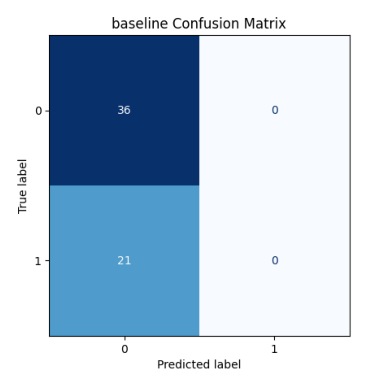

In [47]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Download the folder with plots
plots_dir = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="plots")

# Check what files exist
print(os.listdir(plots_dir))

# Build the full path (make sure spelling matches your saved file)
conf_matrix_path = os.path.join(plots_dir, "confusion_matrix.png")

# Load and display in Jupyter
img = mpimg.imread(conf_matrix_path)
plt.imshow(img)
plt.axis("off")
plt.show()


['roc_curve.png', 'confusion_matrix.png']


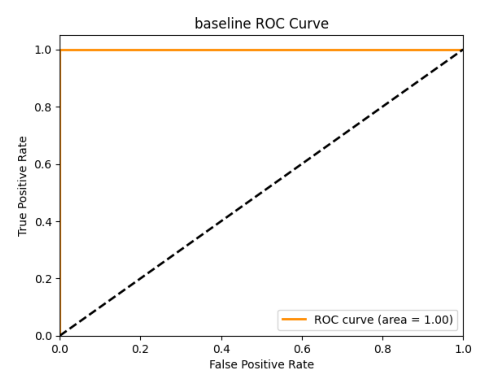

In [48]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Download the folder with plots
plots_dir = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="plots")

# Check what files exist
print(os.listdir(plots_dir))

# Build the full path (make sure spelling matches your saved file)
conf_matrix_path = os.path.join(plots_dir, "roc_curve.png")

# Load and display in Jupyter
img = mpimg.imread(conf_matrix_path)
plt.imshow(img)
plt.axis("off")
plt.show()

## Inference

In [49]:
import numpy as np
import pandas as pd

new_data = np.random.rand(30)


In [50]:
# Convert to DataFrame with proper column names
new_data_df = pd.DataFrame([new_data], columns=features['features'])

scaled_data = scaler.transform(new_data_df)

scaled_data

array([[ -3.86240244,  -4.44922973,  -3.73486459,  -1.84521626,
          1.43460038,   0.47476739,   5.42891317,   3.93639366,
         27.11546842, 106.7032175 ,  -0.94938488,  -0.82568616,
         -0.95942203,  -0.85704112,  23.43205386,  53.96558245,
          4.45416053,  67.44745596,  96.93544436,  69.86167801,
         -3.24430713,  -4.13846096,  -3.16500335,  -1.53672097,
         -2.86719296,  -0.43514362,   0.92044316,   4.25653766,
         -1.43075883,  19.4380798 ]])

In [51]:
y_pred = model.predict(scaled_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [52]:
y_pred

array([[1.8123825e-12]], dtype=float32)

In [53]:
new_data

array([0.46378378, 0.17355795, 0.68976073, 0.88500911, 0.11656625,
       0.12873557, 0.52569144, 0.20323905, 0.92516593, 0.79695883,
       0.13807001, 0.75630391, 0.8929617 , 0.65439321, 0.07455134,
       0.95795806, 0.16827468, 0.43471351, 0.82243805, 0.18322448,
       0.53719393, 0.35656188, 0.19919887, 0.56501959, 0.06578961,
       0.18507312, 0.4641497 , 0.39575243, 0.20227283, 0.43392421])

In [54]:
model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 965 (3.77 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 644 (2.52 KB)

----------_> MARKDOWNS